## Active Learning

Активное обучение $-$ класс алгоритмов обучения моделей машинного обучения. Алгоритмы активного обучения отличаются тем, что могут интерактивно запрашивать пользователя (или некоторый другой источник информации) для разметки новых примеров данных.

<img src="active_learning.png">

## Active Learning Strategies

#### Pool-Based Sampling

В этом сценарии экземпляры извлекаются из всего пула данных и им присваивается информативная оценка, которая показывает, насколько хорошо текущий алгоритм «понимает» данные. 

Затем системой выбираются и размечаются наиболее информативные примеры.

#### Uncertainty sampling


В рамках этого алгоритма размечаются те примеры, в которых текущая модель наименее уверена.

В качестве функций "уверенности" можно использовать вероятности классов или расстояния до разделяющей гиперплоскости.

#### Membership Query Synthesis

Здесь алгоритм обучения модели генерирует свои собственные примеры из некоторого настраиваемого распределения. 
Эти сгенерированные примеры отправляются на разметку, и модель дообучается с учетом разметки этих примеров.

#### Query by Committee

Идея: построить ансамбль моделей $a_1,...,a_T$. 

Выбирать новые объекты $x_i$ с наибольшей несогласованностью решений ансамбля моделей.



Принцип максимума энтропии: выбираем $x_i$, на котором $a_t(x_i)$ максимально различны.

Принцип максимума средней $KL$-дивергенции: выбираем $x_i$ , на котором $P_t(y|x_i)$ максимально различны.

$С(y|u) = \frac{1}{T}\sum_{t=1}^T P_t(y|u)$ - консенсус комитета 

## SVM для Active Learning

Некоторые активные алгоритмы обучения построены на алгоритме SVM и используют структуру SVM для определения того, какие точки данных нужно размечать. 

SVM используется для определения уверенности модели в предсказании на каждом из примеров выборки. 
В качестве меры уверенности служит расстояние от объекта до построенной на текущей итерации разделяющей гиперплоскости.

## Active Learning for text classification

Рассмотрим алгоритм pool-based active learning на примере задачи классификации твитов по тональности.


1. Разделить данные на X_pool (выборка, которую можно размечать) и X_test.
2. Выбрать $k$ примеров из X_pool для начального X_train и разметить их. Остальные данные в X_pool $-$ валидационное множество. 
3. Обучить модель на  X_train.
5. Сделать predict обученной моделью на X_pool, вычислить вероятности для каждого $x_i$.
6. Вычислить качество работы модели на X_test.
7. Выбрать $k$ наиболее информативных объектов из X_pool, основываясь на уверенности модели в каждом из объектов (например, вероятности классов).
8. Переменести эти $k$ выбранных объектов в X_train.
9. Если качество работы модели на X_test достаточное, то останавливаемся, иначе возвращаемся к шагу 3.

In [1]:
from sklearn.metrics import f1_score

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk import ngrams

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
df = pd.read_csv('/content/sample_data/spam_text_classification_data.csv')
print(df.shape)
df.head()

(5572, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['label'] = [0 if category == 'ham' else 1 for category in df['Category']]

In [7]:
X,X_test,y,y_test = train_test_split(np.array(df['Message']), np.array(df['label']))

In [8]:
def get_confidence(class_probs):
    return abs(0.5-class_probs[0])

In [9]:
train_size = 50

dataset_size = X.shape[0]
target_score = 0.95
score = 0
step = 10

X_train = X[:train_size]
y_train = y[:train_size]
X_pool = X[train_size:]
y_pool = y[train_size:]

scores = [0]
train_szs = [0]

while score < target_score and train_size <= dataset_size:
    vec = CountVectorizer(ngram_range=(1, 3))
    bow = vec.fit_transform(X_train)
    clf = LogisticRegression()
    clf = clf.fit(bow,y_train)
    pred = clf.predict(vec.transform(X_test))
    
    print("{0} train samples".format(train_size))
    print(classification_report(pred, y_test))
    score = f1_score(pred, y_test)
    scores.append(score)
    train_szs.append(train_size)
    
    pred_probs = clf.predict_proba(vec.transform(X_pool))
    confidences = [get_confidence(probs) for probs in pred_probs]
    
    X_train = np.concatenate([X_train, X_pool[np.argsort(confidences)[:step]]])
    y_train = np.concatenate([y_train, y_pool[np.argsort(confidences)[:step]]])
    X_pool = X_pool[sorted(np.argsort(confidences)[step:])]
    y_pool = y_pool[sorted(np.argsort(confidences)[step:])]
    train_size += step

50 train samples
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1391
           1       0.01      1.00      0.02         2

    accuracy                           0.87      1393
   macro avg       0.51      0.93      0.47      1393
weighted avg       1.00      0.87      0.93      1393

60 train samples
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1384
           1       0.05      1.00      0.09         9

    accuracy                           0.87      1393
   macro avg       0.52      0.94      0.51      1393
weighted avg       0.99      0.87      0.93      1393

70 train samples
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1378
           1       0.08      1.00      0.15        15

    accuracy                           0.88      1393
   macro avg       0.54      0.94      0.54      1393
weighted avg       0.99

In [10]:
vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(X)
clf = clf.fit(bow,y)
pred = clf.predict(vec.transform(X_test))

print("{0} train samples".format(dataset_size))
print(classification_report(pred, y_test))

4179 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1232
           1       0.86      1.00      0.92       161

    accuracy                           0.98      1393
   macro avg       0.93      0.99      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [11]:
from matplotlib import pyplot as plt

%matplotlib inline

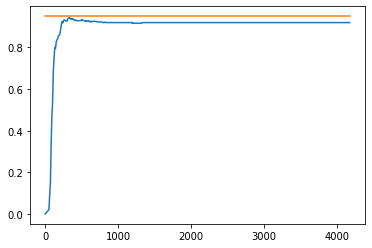

In [12]:
plt.plot(train_szs,scores)
plt.plot(train_szs, [0.95 for sz in train_szs])

Можно видеть, что для достижения лучшего качества на этом датасете достаточно обучиться на 300 правильно выбранных примерах.